In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor

use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu") 

PATH = "save/trained_cnn_model.pt"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307), (0.3081))])


# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True,  transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)   # 3: kernel size, 1: stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # make a vector
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) # voting
        return output

model = Net().to(device)
print(model)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

/home/m7kang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/m7kang/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


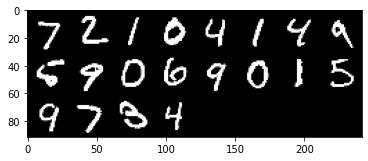

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter) ## If you run this line, the next data batch is called subsequently.

# show images
imshow(torchvision.utils.make_grid(images))

In [3]:
import os
if not os.path.exists('./save'):
    os.makedirs('./save')
    
import time

# number of epochs to train the model
n_epochs = 10  
# per epoch, all the training data set is used once
model.train() # prep model for training

start_time = time.time()
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        data, target = data.to(device), target.to(device) # loading to GPU
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0) # as loss is tensor, .item() needed to get the value
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    
    
    end_time = time.time()
    
    elapsed_time = end_time - start_time

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
    
    
    
# see following link for details of state_dict   
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, PATH)

Epoch: 1 	Training Loss: 0.038079
Epoch: 2 	Training Loss: 0.034796
Epoch: 3 	Training Loss: 0.032845
Epoch: 4 	Training Loss: 0.031492
Epoch: 5 	Training Loss: 0.029433
Epoch: 6 	Training Loss: 0.028314
Epoch: 7 	Training Loss: 0.026631
Epoch: 8 	Training Loss: 0.025666
Epoch: 9 	Training Loss: 0.022859
Epoch: 10 	Training Loss: 0.023790


In [4]:
elabsed_time

226.85092163085938

In [2]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']

In [ ]:
checkpoint.keys()
model_dict = checkpoint['model_state_dict']
model_dict['conv1.weight']


In [3]:
### Can be run without training again by using checkpoint

model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device) # loading to GPU
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 9905/10000 (99%)



In [5]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
    def __call__(self, module, module_in):
        self.outputs.append(module_in)
    def clear(self):
        self.outputs = []  
        
######### Save inputs from selected layer ##########
save_output = SaveOutput()

for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d):
        print("prehooked")
        layer.register_forward_pre_hook(save_output)       ## Input for the module will be grapped       
####################################################

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.to(device)
out = model(images)
print("1st convolution's input size:", save_output.outputs[0][0].size())
print("2nd convolution's input size:", save_output.outputs[1][0].size())

prehooked
prehooked
1st convolution's input size: torch.Size([20, 1, 28, 28])
2nd convolution's input size: torch.Size([20, 32, 26, 26])


In [ ]:
for layer in model.modules():
    print(layer)

In [8]:
save_output.outputs[0][0]

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [ ]:
my_input = save_output.outputs[0][0]
images.size()

In [ ]:
m = model.conv1

In [ ]:
my_output = F.relu(m(my_input))

In [ ]:
(my_output - save_output.outputs[1][0]).sum()

In [12]:
a.sign()

tensor([1])